# Brain Tumor Segmentation with U-Net (PyTorch)

This notebook demonstrates a deep learning pipeline to segment brain tumors from MRI scans using the BraTS dataset format, implemented in PyTorch.

## 1. Setup and Dependencies
We will load the necessary libraries and our custom helper modules.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Import our custom modules
from data_loader import load_sample, normalize_volume, process_mask_multiclass, get_2d_slices, BraTSDataset
from unet_model_torch import UNet

print(f"PyTorch Version: {torch.__version__}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

2026-01-05 22:26:35.897725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-05 22:26:35.954908: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


PyTorch Version: 2.9.1+cu128
Using device: cpu


2026-01-05 22:26:37.461411: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 2. Configuration
Set parameters for data loading and training.

In [2]:
CASE_PATH = "/home/prabanjan/Downloads/BraTS2021_00495"
CASE_ID = "BraTS2021_00495"
IMG_HEIGHT = 240
IMG_WIDTH = 240
CHANNELS = 4
NUM_CLASSES = 4
BATCH_SIZE = 8
EPOCHS = 3

## 3. Data Loading and Preprocessing
We load the MRI volumes, normalize them, and extract 2D slices.

In [3]:
print("Loading and Preprocessing Data...")
X, Y = load_sample(CASE_PATH, CASE_ID)
print(f"Original Volume Shape: {X.shape}")

X_norm = normalize_volume(X)
Y_proc = process_mask_multiclass(Y)

print("Extracting 2D Slices...")
X_slices, Y_slices = get_2d_slices(X_norm, Y_proc)
print(f"Total slices: {len(X_slices)}")

Loading and Preprocessing Data...
Original Volume Shape: (240, 240, 155, 4)
Extracting 2D Slices...
Total slices: 137


## 4. Train/Validation Split and Dataloaders

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X_slices, Y_slices, test_size=0.2, random_state=42)

train_dataset = BraTSDataset(X_train, Y_train)
val_dataset = BraTSDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 109
Validation samples: 28


## 5. Model Building
We use a standard U-Net architecture.

In [5]:
print("Building U-Net...")
model = UNet(n_channels=CHANNELS, n_classes=NUM_CLASSES, start_filters=16)
model.to(DEVICE)
print(model)

Building U-Net...
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

## 6. Training Functions
Define loss, optimizer and training loop.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred_soft = torch.softmax(y_pred, dim=1) 
    y_true_oh = torch.nn.functional.one_hot(y_true, num_classes=NUM_CLASSES) # (N, H, W, C)
    y_true_oh = y_true_oh.permute(0, 3, 1, 2) # (N, C, H, W)
    
    intersection = torch.sum(y_pred_soft * y_true_oh, dim=(0, 2, 3))
    union = torch.sum(y_pred_soft, dim=(0, 2, 3)) + torch.sum(y_true_oh, dim=(0, 2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

## 7. Training
Train model on prepared data.

In [7]:
history = {'train_loss': [], 'val_loss': [], 'val_dice': []}

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coef(masks, outputs).item()
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    
    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(avg_val_dice)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}")

Starting training...
Epoch 1/3, Train Loss: 1.2780, Val Loss: 1.3474, Val Dice: 0.1102
Epoch 2/3, Train Loss: 1.0110, Val Loss: 0.9479, Val Dice: 0.1499
Epoch 3/3, Train Loss: 0.8134, Val Loss: 0.7390, Val Dice: 0.1729


## 8. Evaluation and Visualization
Visualize predictions.

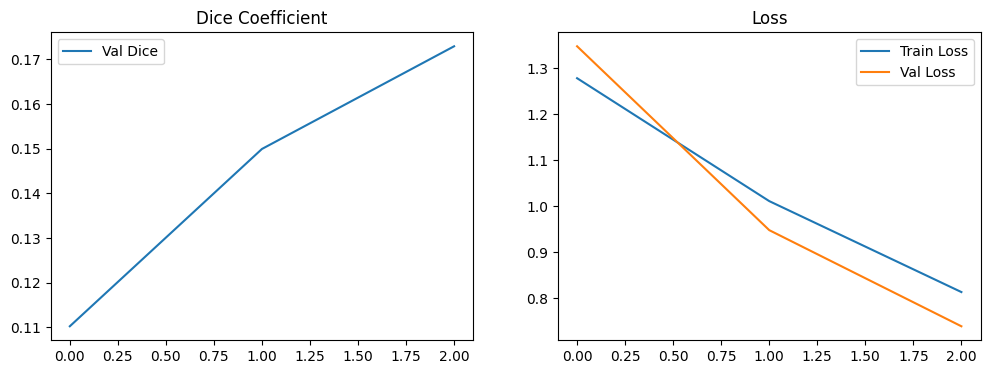

In [8]:
# Plot history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['val_dice'], label='Val Dice')
plt.title('Dice Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

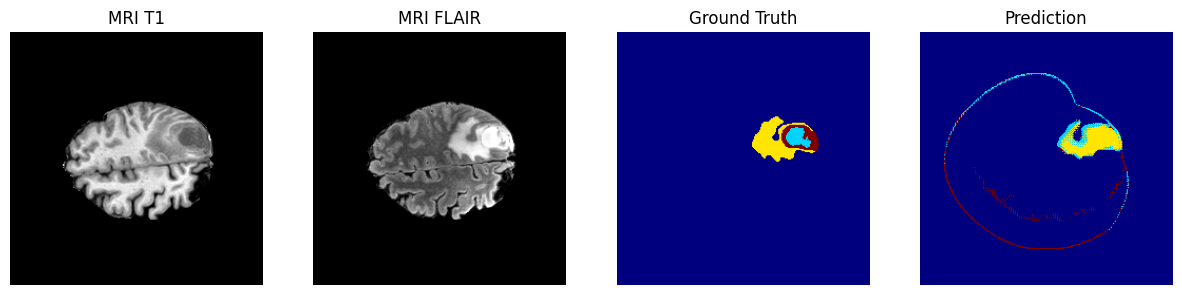

In [9]:
model.eval()
# Get one batch
images, masks = next(iter(val_loader))
images = images.to(DEVICE)
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1) # (N, H, W)
    
# Visualize
idx = 0
img_np = images[idx].cpu().permute(1, 2, 0).numpy() # (C, H, W) -> (H, W, C)
mask_true = masks[idx].cpu().numpy()
mask_pred = preds[idx].cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("MRI T1")
plt.imshow(img_np[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("MRI FLAIR")
plt.imshow(img_np[:, :, 3], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Ground Truth")
plt.imshow(mask_true, cmap='jet', vmin=0, vmax=3)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Prediction")
plt.imshow(mask_pred, cmap='jet', vmin=0, vmax=3)
plt.axis('off')

plt.show()